### Author: Mohsen Ghazel (mghazel)
* Date: April 1st, 2021

# **Project: Cell nuclei segmentation using U-Net**

The this project, we develop a U-Net to detect and segment cells’ nuclei:

* A human body’s has in the order of 30 trillion cells:
  * Each cell contain a nucleus full of DNA, the genetic code that programs each cell. 
  * Identifying the cells’ nuclei is the starting point for most analyses because 
  * Identifying nuclei allows researchers to identify each individual cell in a sample
  * Measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work.

We shall demonstrate the end-to-end process of segmenting cells' nuclei using U-Net.

##**Step 1: Python imports and global variables**



### 1.1) Imports

In [ ]:
print(__doc__)

Automatically created module for IPython interactive environment


In [1]:
# Numpy
import numpy as np
# matplot lib
import matplotlib.pyplot as plt
# opencv
import cv2
# PIL library
from PIL import Image
# tensorflow
import tensorflow as tf
# keras
import keras

# sklearn imports
# - nededed for splitting the dataset into training and testing subsets
from sklearn.model_selection import train_test_split
# - nededed for 1-hot coding of the image labels
from keras.utils import to_categorical

# tqdm
from tqdm import tqdm 

# skimage
# read and imshow
from skimage.io import imread, imsave, imshow
# resize
from skimage.transform import resize

# Image package
from IPython.display import Image
# using HTML code
from IPython.core.display import HTML 

# set the keras backend to tensorflow
# os.environ['KERAS_BACKEND'] = 'tensorflow'
# I/O
import os
# sys
import sys

# datetime
import datetime

# random
import random

# check for successful package imports and versions
# python
print("Python version : {0} ".format(sys.version))
# OpenCV
print("OpenCV version : {0} ".format(cv2.__version__))
# numpy
print("Numpy version  : {0}".format(np.__version__))

Python version : 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0] 
OpenCV version : 4.1.2 
Numpy version  : 1.19.5


In [2]:
# mount my Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2) Global variables

In [18]:
#-------------------------------------------------------------------------------
# We set the Numpy pseudo-random generator at a fixed value:
#-------------------------------------------------------------------------------
# - This ensures repeatable results everytime you run the code. 
# the seed 
RANDOM_SEED = 101
# set the random seed
np.random.seed = RANDOM_SEED

#-------------------------------------------------------------------------------
# Set the random state to 101
#-------------------------------------------------------------------------------
# - This ensures repeatable results everytime you run the code. 
RANDOM_STATE = 101

#-------------------------------------------------------------------------------
# Set the sample images path
#-------------------------------------------------------------------------------
# - contains sample images such as the implemented U-Net structure
SAMPLE_IMAGES_PATH = "/content/drive/MyDrive/mghazel-pro-dev/projects/YouTube/DigitalSreeni/U-Net/code/sample-images/"

#-------------------------------------------------------------------------------
# Set the data directory where cell-nuclei data sets are stored
#-------------------------------------------------------------------------------
# training images
TRAIN_IMAGES_PATH = '/content/drive/MyDrive/mghazel-pro-dev/projects/YouTube/DigitalSreeni/U-Net/cell-nuclei-data/stage1_train/'

# test images
TEST_IMAGES_PATH = '/content/drive/MyDrive/mghazel-pro-dev/projects/YouTube/DigitalSreeni/U-Net/cell-nuclei-data/stage1_test/'

#-------------------------------------------------------------------------------
# Set the input images size: RGB images with size: 128x128 pixels
#-------------------------------------------------------------------------------
# input image-width
INPUT_IMAGE_WIDTH = 128
# input image-width
INPUT_IMAGE_HEIGHT = 128
# input image-channels
INPUT_IMAGE_CHANNELS = 3

#-------------------------------------------------------------------------------
# A flag to combine seperate ground-truth cell-nuclei masks into one 
# common mask:
#-------------------------------------------------------------------------------
# - Set this flag to 1 to combine
# - Set this flag to 0 to use the already combined mask
#-------------------------------------------------------------------------------
COMBINE_GROUND_TRUTH_MASKS = 1
# the name of tthe file of the combined mask
COMBINED_MASK_FILE_NAME = 'combined_gt_mask.png'

##**Step 2: Read, resize and visualize the input data set**

* We use the following dataset:
  * Kaggle 2018 Data Science Bowl: 
    * Objective: Find the nuclei in divergent images to advance medical discovery
    * Link: https://www.kaggle.com/c/data-science-bowl-2018/data
  * The dataset contains a large number of segmented nuclei images:
    * Training data subset: 
      * 670 nuclei cell annotated images (in the sub-folder: \images)
        * For each image, ground-truth annotation masks associated with each nucleus cell ((in the sub-folder: \masks).
    * Test data subset: 
      * 65 images without ground-truth (in the sub-folder: \images).
    * The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence)    
    * The dataset is designed to challenge an algorithm's ability to generalize across these variations.




### 2.1) Read and resize and visualize the training data subset:
*  There are 670 nuclei cell annotated images (in the sub-folder: \images)
  * For each image, ground-truth annotation masks associated with each nucleus cell ((in the sub-folder: \masks).

#### 2.1.1) Read and resize the input training images

In [ ]:
#-------------------------------------------------------------------------------
# The structure of the training-data folder is as follows:
#-------------------------------------------------------------------------------
# - For each training image: 
#
#  - \stage1_train\52b267e20519174e3ce1e1994b5d677804b16bc670aa5f6ffb6344a0fdf63fde\images
#  - \stage1_train\52b267e20519174e3ce1e1994b5d677804b16bc670aa5f6ffb6344a0fdf63fde\masks
#
#-------------------------------------------------------------------------------
# This needs to be parsed to extract the the ID for each image:
#
#    52b267e20519174e3ce1e1994b5d677804b16bc670aa5f6ffb6344a0fdf63fde
#
#-------------------------------------------------------------------------------
# display a message
print("\n-------------------------------------------------------------------------")
print("Reading and formatting the training images:")
print("-------------------------------------------------------------------------")
# extract the IDs for the training images
train_ids = next(os.walk(TRAIN_IMAGES_PATH))[1]

# the number of train images
num_train_images = len(train_ids)
# display a message
print("The number of train images = {0}".format(num_train_images))
#-------------------------------------------------------------------------------
# Allocate a data structure to store the read and resized train images: 
#-------------------------------------------------------------------------------
# 1) 4D numpy array to store the images:
#     - The number of training images: (len(train_ids)
#     - Each training image will be resized to: 
#       - INPUT_IMAGE_HEIGHT x INPUT_IMAGE_WIDTH x INPUT_IMAGE_CHANNELS
#-------------------------------------------------------------------------------
X_train = np.zeros((len(train_ids), 
                    INPUT_IMAGE_HEIGHT, 
                    INPUT_IMAGE_WIDTH, 
                    INPUT_IMAGE_CHANNELS), dtype=np.uint8)
#-------------------------------------------------------------------------------
# 2) 3D numpy array to store the masks:
#     - The number of training images: (len(train_ids)
#     - Each training grayscale/binary image-mask will be resized to: 
#       - INPUT_IMAGE_HEIGHT x INPUT_IMAGE_WIDTH x 1
#-------------------------------------------------------------------------------
Y_train = np.zeros((len(train_ids), 
                    INPUT_IMAGE_HEIGHT, 
                    INPUT_IMAGE_WIDTH, 1), 
                   dtype=np.bool)

#-------------------------------------------------------------------------------
# Save the common mask:
#------------------------------------------------------------------------------- 
# Once the seperate masks are combined together, save the combined mask:
#------------------------------------------------------------------------------- 
# - This will speed up the prcessing
# - It is very slow to read the many individual masks
# - Instead, we just read the combined mask
#------------------------------------------------------------------------------- 
# the combined mask name
combined_mask_name = 'combined_mask.png';

#-------------------------------------------------------------------------------
# Read and resize each training image
#-------------------------------------------------------------------------------
# iterate over the training-images IDs
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    # set the path of the next training image
    path = TRAIN_IMAGES_PATH + id_
    # read the next train image
    img = imread(path + '/images/' + id_ + '.png')[:,:,:INPUT_IMAGE_CHANNELS]
    #---------------------------------------------------------------------------
    # resize the read training image to the specified desired size:
    #---------------------------------------------------------------------------
    # - INPUT_IMAGE_HEIGHT x INPUT_IMAGE_WIDTH
    #---------------------------------------------------------------------------
    img = resize(img, (INPUT_IMAGE_HEIGHT, 
                       INPUT_IMAGE_WIDTH), 
                       mode='constant', 
                       preserve_range=True)
    # store the resized train image in the X_train 4D arrays 
    X_train[n] = img
    #---------------------------------------------------------------------------
    # The ground-truth annotation masks stored in /masks subfolder:
    #---------------------------------------------------------------------------
    #  - A seperate mask is prvided for each cell nucleus in the image
    #  - These masks need to be merged together into one mask
    #---------------------------------------------------------------------------
    # initialize the common mask
    mask = np.zeros((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH, 1), dtype=np.bool)
    #---------------------------------------------------------------------------
    # Check if we need to combined the masks into a single common mask:
    #---------------------------------------------------------------------------
    if ( COMBINE_GROUND_TRUTH_MASKS == 1 ):
        #-----------------------------------------------------------------------
        # Read and combined the individual masks into one mask:
        #-----------------------------------------------------------------------
        # iterate over each eask mask file in the /masks sub-folder
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            # read the new mask image
            mask_ = imread(path + '/masks/' + mask_file)
            #-------------------------------------------------------------------
            # Resize the mask image as done for the image:
            #-------------------------------------------------------------------
            # - Each training grayscale/binary image-mask will be resized to: 
            # - INPUT_IMAGE_HEIGHT x INPUT_IMAGE_WIDTH x 1 
            #-------------------------------------------------------------------
            mask_ = np.expand_dims(resize(mask_, (INPUT_IMAGE_HEIGHT, 
                                                  INPUT_IMAGE_WIDTH), mode='constant',  
                                                  preserve_range=True), axis=-1)
            #-------------------------------------------------------------------
            # Append this resized new mask image to the combined mask image:
            #-------------------------------------------------------------------
            # - This is done by taking the max() operator between the 2 masks
            #-------------------------------------------------------------------
            mask = np.maximum(mask, mask_)  
        #-----------------------------------------------------------------------
        # Store the combined cell nuclei mask:
        #-----------------------------------------------------------------------
        Y_train[n] = mask 
        #-----------------------------------------------------------------------
        # Save the combined mask to file
        #-----------------------------------------------------------------------
        # the full-path file
        combined_mask_full_path_file_name = path + '/masks/' + COMBINED_MASK_FILE_NAME
        # save the combined mask image
        imsave(combined_mask_full_path_file_name, np.uint8(mask)) 
    #-----------------------------------------------------------------------------
    # If the masks have already been combined into a single common mask:
    #-----------------------------------------------------------------------------
    else: 
        #-----------------------------------------------------------------------
        # Read the combined mask
        #-----------------------------------------------------------------------
        # the full-path file
        combined_mask_full_path_file_name = path + '/masks/' + COMBINED_MASK_FILE_NAME
        # read the combined mask image
        mask = imread(combined_mask_full_path_file_name) 
        #-----------------------------------------------------------------------
        # Store the combined cell nuclei mask:
        #-----------------------------------------------------------------------
        Y_train[n] = mask 

#-------------------------------------------------------------------------------
# display a message
#-------------------------------------------------------------------------------
print("\nTraining images and ground-truth masks are read, resized and stored successfully!")


#### 2.1.2) Visualize 8 sample training images
* Visualize 8 sample training images and their associated cell nuclei masks:

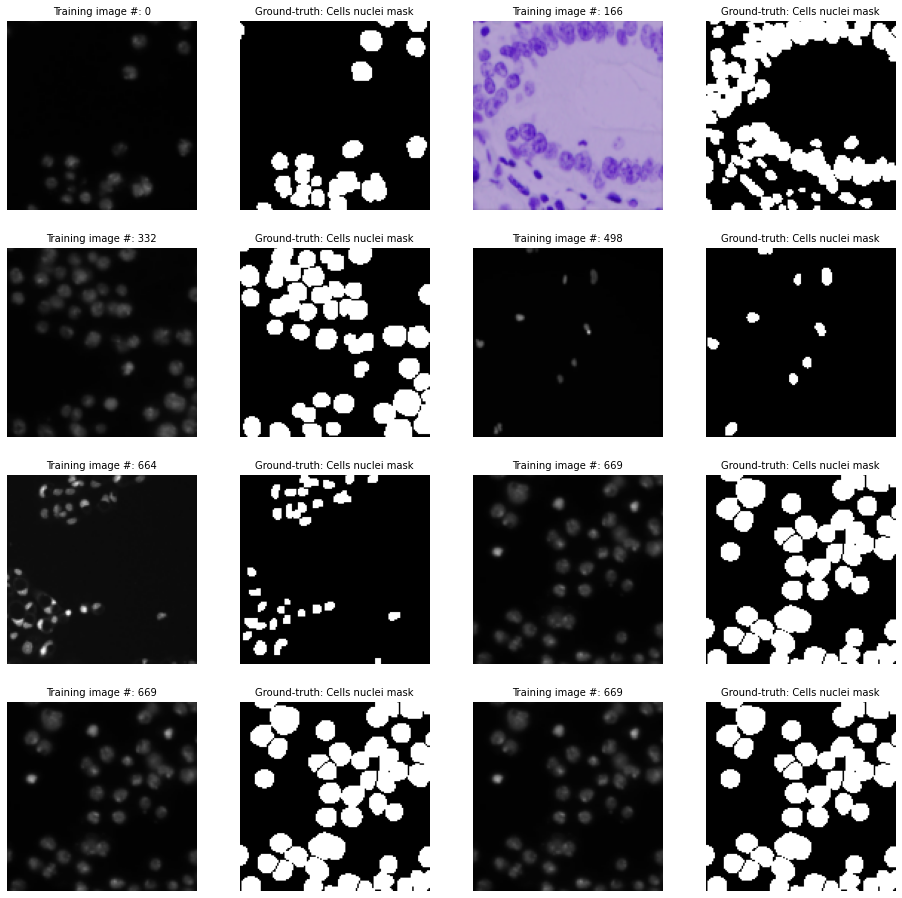

In [68]:
#-----------------------------------------------------------------
# - Visualize 8 cell nuclei training images and their associated 
#   ground-truth cell neclei masks:
#-----------------------------------------------------------------
# set the number of skipped images
# - integer division
NUM_SKIPPED_IMAGES = num_train_images // 8
# specify the overall grid size
plt.figure(figsize=(16,16)) 
plt.title("Cell nuclei test images", fontsize=12)
# iterate over the 16 images
for i in range(0, 16, 2): 
    # image counter 
    image_counter = np.min([i * NUM_SKIPPED_IMAGES, num_train_images - 1])
    #---------------------------------------------------------------------------
    # step 1: create the subplot for the image 
    #---------------------------------------------------------------------------
    plt.subplot(4,4,i+1)  
    # display the image
    plt.imshow(X_train[image_counter])
    # figure title
    plt.title("Training image #: " + str(image_counter), fontsize=10)
    # turn-off axes
    plt.axis('off')
    #---------------------------------------------------------------------------
    # step 2: create the subplot for the image ground-truth cell nuclei mask
    #---------------------------------------------------------------------------
    plt.subplot(4,4,i+2)  
    # display the image
    plt.imshow(np.squeeze(Y_train[image_counter]), cmap='gray')
    # figure title
    plt.title("Ground-truth: Cells nuclei mask", fontsize=10)
    # turn-off axes
    plt.axis('off')

### 2.2) Read and resize and visualize the test data subset:
* There are 65 test images without ground-truth:

#### 2.2.1) Read and resize the input test images


In [12]:
#-------------------------------------------------------------------------------
# The structure of the test-data folder is as follows:
#-------------------------------------------------------------------------------
# - For each test image: 
#
#  ...\stage1_test\0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732\images
#
#-------------------------------------------------------------------------------
# This needs to be parsed to extract the the ID for each image:
#
#    0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732
#
#-------------------------------------------------------------------------------
# display a message
print("\n-------------------------------------------------------------------------")
print("Reading and formatting the test images:")
print("-------------------------------------------------------------------------")
# extract the IDs for the test images
test_ids = next(os.walk(TEST_IMAGES_PATH))[1]

# the number of test images
num_test_images = len(test_ids)
# display a message
print("The number of test images = {0}".format(num_test_images))
#-------------------------------------------------------------------------------
# Allocate a data structure to store the read and resized test images: 
#-------------------------------------------------------------------------------
# - 4D numpy array to store:
#   - The number of test images: (len(test_ids)
#   - Each test image is: INPUT_IMAGE_HEIGHT x INPUT_IMAGE_WIDTH x INPUT_IMAGE_CHANNELS
#-------------------------------------------------------------------------------
X_test = np.zeros((len(test_ids), 
                   INPUT_IMAGE_HEIGHT, 
                   INPUT_IMAGE_WIDTH, 
                   INPUT_IMAGE_CHANNELS), 
                  dtype=np.uint8)

#-------------------------------------------------------------------------------
# Allocate a structure to store the original size of the test images
#-------------------------------------------------------------------------------
sizes_test = []

#-------------------------------------------------------------------------------
# Read and resize each test image
#-------------------------------------------------------------------------------
# iterate over the test-images IDs
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    # set the path of the next test image
    path = TEST_IMAGES_PATH + id_
    # read the next test image
    img = imread(path + '/images/' + id_ + '.png')[:,:,:INPUT_IMAGE_CHANNELS]
    # store its original size and append ut to the sizes_test list
    sizes_test.append([img.shape[0], img.shape[1]])
    # resize the read test image to the specified desired size:
    # - INPUT_IMAGE_HEIGHT x INPUT_IMAGE_WIDTH
    img = resize(img, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), mode='constant', preserve_range=True)
    # store the resized test image in the X_test 4D arrays 
    X_test[n] = img

#-------------------------------------------------------------------------------
# display a message
#-------------------------------------------------------------------------------
print("\nTest images read, resized and stored successfully!")


  0%|          | 0/65 [00:00<?, ?it/s]


-------------------------------------------------------------------------
Reading and formatting the test images:
-------------------------------------------------------------------------
The number of test images = 65



100%|██████████| 65/65 [00:50<00:00,  1.29it/s]


Test images read, resized and stored successfully!


#### 2.2.2) Visualize 16 sample test images


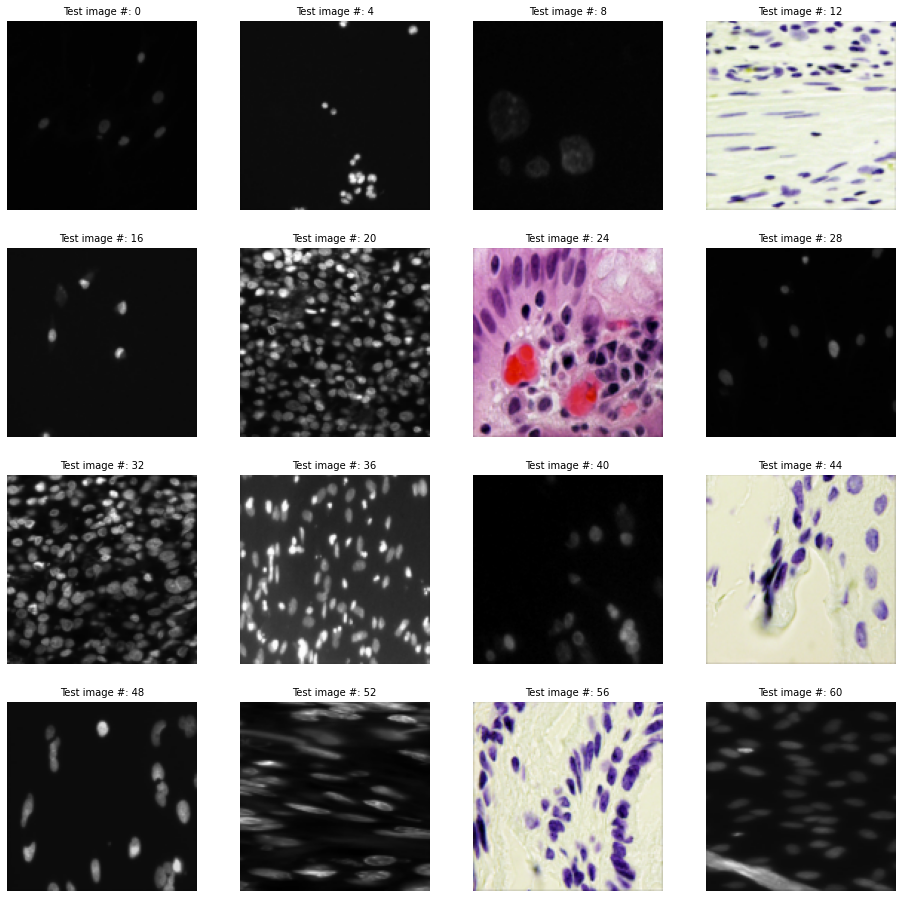

In [13]:
#-----------------------------------------------------------------
# - Visualize 16 cell nuclei test images:
#-----------------------------------------------------------------
# set the number of skipped images
# - integer division
NUM_SKIPPED_IMAGES = num_test_images // 16
# specify the overall grid size
plt.figure(figsize=(16,16)) 
plt.title("Cell nuclei test images", fontsize=12)
# iterate over the 16 images
for i in range(16):
    # image counter 
    image_counter = np.min([i * NUM_SKIPPED_IMAGES, num_test_images - 1])
    # create the subplot for the next image
    plt.subplot(4,4,i+1)   
    # display the image
    plt.imshow(X_test[image_counter])
    # figure title
    plt.title("Test image #: " + str(image_counter), fontsize=10)
    # set axis off
    plt.axis('off')

##**Step 3: Build the U-Net model**
 
* Build the U-Net model:
    * A sequence of convolutional and pooling layers.
    * With some some normalization and dropout layers in between.
* Experiment with different structures and hyper parameters


### 3.1) Display the structure of the implemented U-Net model:

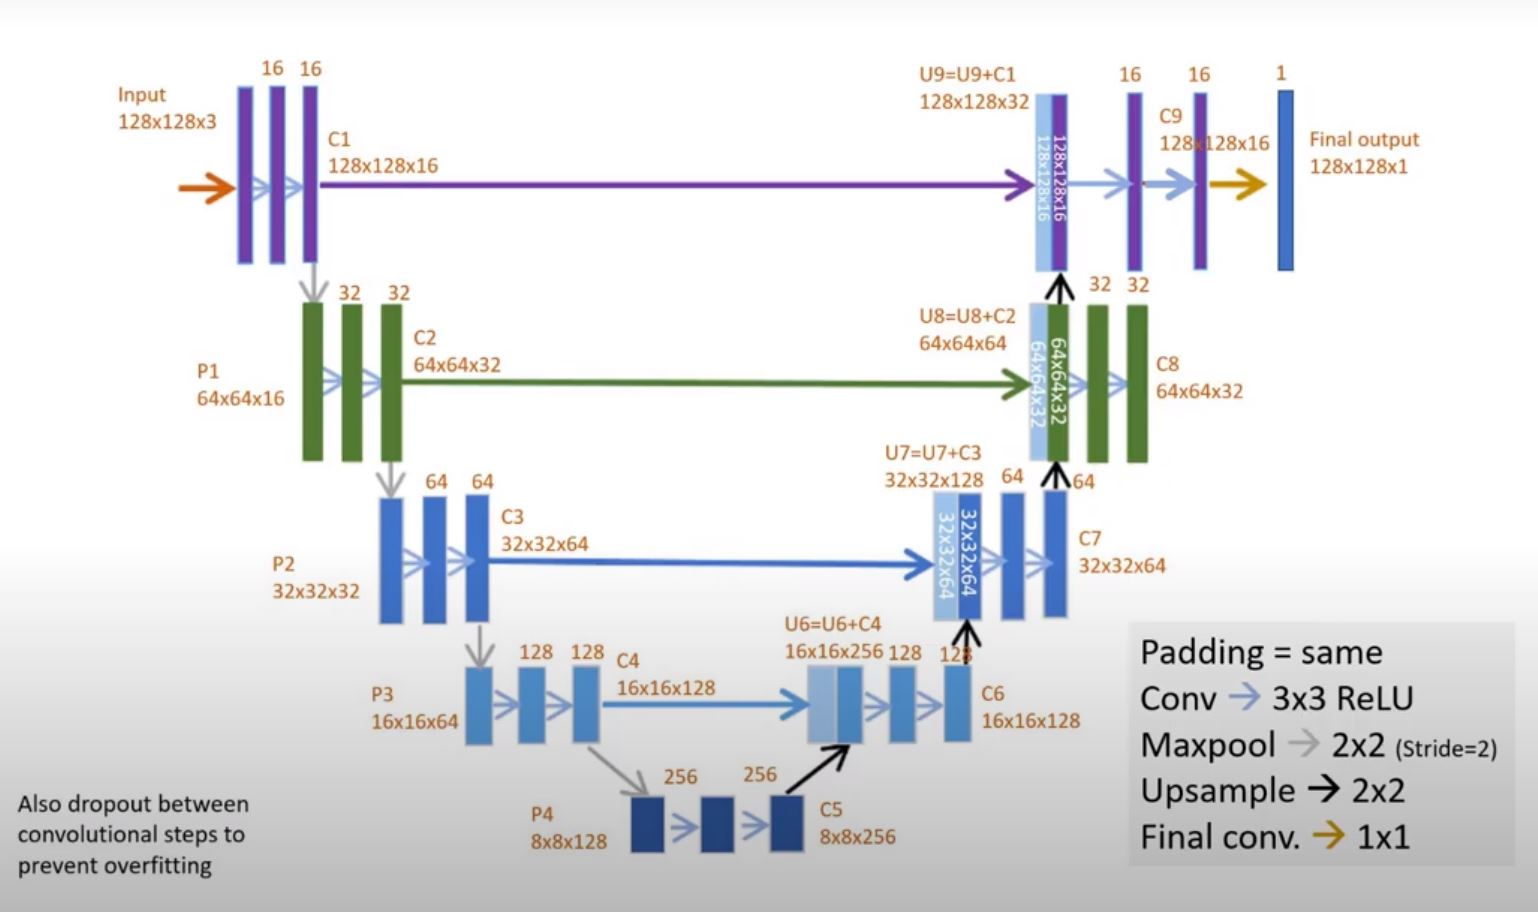

In [30]:
#-------------------------------------------------------------------------------
# Display the structure of the implemented U-Net:
#-------------------------------------------------------------------------------
# set the image dimensions and preserve its aspect-ratio:
#-------------------------------------------------------------------------------
# height
img_height = 400
# width
img_width = 600
# display the image
Image(filename = SAMPLE_IMAGES_PATH + "Implemented-U-Net.JPG", width=img_width, height=img_height)

### 3.2) Define the U-Net model layers:


In [31]:
#===============================================================================
# Define sequential layers of the U-Net model:
#===============================================================================
# 1) Input layer with image size: 
#    - INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH, INPUT_IMAGE_CHANNELS
#-------------------------------------------------------------------------------
inputs = tf.keras.layers.Input((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH, INPUT_IMAGE_CHANNELS))
# normalize the input image to the interval: [0,1]
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#===============================================================================
# 2) Contaction path:
#===============================================================================
# 2.1) Convolutional layers: C1 and P1
#-------------------------------------------------------------------------------
# Convolution layer with 32 filters of size: 3x3 and preserve image size 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# Apply 10 % dropout
c1 = tf.keras.layers.Dropout(0.1)(c1)
# Convolution layer with 16 filters of size: 3x3 and preserve image size 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
# Apply 2x2 max-pooling
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

#-------------------------------------------------------------------------------
# 2.2) Convolutional layers: C2 and P2
#------------------------------------------------------------------------------
# Convolution layer with 32 filters of size: 3x3 and preserve image size
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
# Apply 10 % dropout
c2 = tf.keras.layers.Dropout(0.1)(c2)
# Convolution layer with 32 filters of size: 3x3 and preserve image size
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
# Apply 2x2 max-pooling
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

#-------------------------------------------------------------------------------
# 2.3) Convolutional layers: C3 and P3
#-------------------------------------------------------------------------------
# Convolution layer with 64 filters of size: 3x3 and preserve image size
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
# Apply 20 % dropout
c3 = tf.keras.layers.Dropout(0.2)(c3)
# Convolution layer with 64 filters of size: 3x3 and preserve image size
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
# Apply 2x2 max-pooling
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

#-------------------------------------------------------------------------------
# 2.4) Convolutional layers: C4 and P4
#-------------------------------------------------------------------------------
# Convolution layer with 128 filters of size: 3x3 and preserve image size
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
# Apply 20 % dropout
c4 = tf.keras.layers.Dropout(0.2)(c4)
# Convolution layer with 128 filters of size: 3x3 and preserve image size
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
# Apply 2x2 max-pooling
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

#-------------------------------------------------------------------------------
# 2.4) Convolutional layers: C4 and P4
#-------------------------------------------------------------------------------
# Convolution layer with 256 filters of size: 3x3 and preserve image size
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
# Apply 20 % dropout
c5 = tf.keras.layers.Dropout(0.3)(c5)
# Convolution layer with 256 filters of size: 3x3 and preserve image size
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#===============================================================================
# 3) Expansive path:
#===============================================================================
# 3.1) Convolutional layers: U6 and C6
#-------------------------------------------------------------------------------
# Convolution layer with 128 filters of size: 2x2 and preserve image size
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
# concatenate to up-sample
u6 = tf.keras.layers.concatenate([u6, c4])
# Convolution layer with 128 filters of size: 3x3 and preserve image size
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
# Apply 20 % dropout
c6 = tf.keras.layers.Dropout(0.2)(c6)
# Convolution layer with 128 filters of size: 3x3 and preserve image size
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
#-------------------------------------------------------------------------------
# 3.2) Convolutional layers: U7 and C7
#-------------------------------------------------------------------------------
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
# concatenate to up-sample
u7 = tf.keras.layers.concatenate([u7, c3])
# Convolution layer with 64 filters of size: 3x3 and preserve image size
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
# Apply 20 % dropout
c7 = tf.keras.layers.Dropout(0.2)(c7)
# Convolution layer with 64 filters of size: 3x3 and preserve image size
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
#-------------------------------------------------------------------------------
# 3.3) Convolutional layers: U8 and C8
#-------------------------------------------------------------------------------
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
# concatenate to up-sample
u8 = tf.keras.layers.concatenate([u8, c2])
# Convolution layer with 32 filters of size: 3x3 and preserve image size
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
# Apply 10 % dropout
c8 = tf.keras.layers.Dropout(0.1)(c8)
# Convolution layer with 32 filters of size: 3x3 and preserve image size
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
#-------------------------------------------------------------------------------
# 3.4) Convolutional layers: U9 and C9
#-------------------------------------------------------------------------------
# Convolution layer with 16 filters of size: 1x2 and preserve image size
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
# concatenate to up-sample
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
# Convolution layer with 16 filters of size: 3x3 and preserve image size
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
# Apply 10 % dropout
c9 = tf.keras.layers.Dropout(0.1)(c9)
# Convolution layer with 16 filters of size: 3x3 and preserve image size
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

#===============================================================================
# 4) Output layer:
#===============================================================================
# final output layer 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

####3.3) Construct the Keras model using the above defined layers

In [32]:
#-------------------------------------------------------------------------------
# Define the Keras model using the above defined layers:
#-------------------------------------------------------------------------------
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

####3.4) Compile the CNN model

In [33]:
#-------------------------------------------------------------------------------
# Compile the model
#-------------------------------------------------------------------------------
#  - Experiment with using:
#      - binary_crossentropy: suitable for binary classification 
#      - categorical_crossentropy: suitable for multi-class classification 
#-------------------------------------------------------------------------------
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

####3.5) Print the model summary

In [69]:
#-------------------------------------------------------------------------------
# Printout the model summary
#-------------------------------------------------------------------------------
# print model summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

##**Step 4: Fit/train the model**

* Train the model on the training data set


### 4.1) Define callbacks
* Define callbacks for early for:
  * Early stopping
  * Monitoring training

#### 4.1.1) Saving the model trained model checkpoint in case of failture or early termination

In [35]:
# Save the best trained model checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('cell_nuclei_segmentation_u-net_model_temp.h5', verbose=1, save_best_only=True)

#### 4.1.2) Early stopping and Tensorboard monitoring

In [36]:
# Stop training if validation accuracy does not improved after 2 consecutive epochs
# - Save files in logs for tensorboard monitoring
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

4.1.3) Start training the model

In [37]:
#-------------------------------------------------------------------------------
# Train the model for the specified number of training epochs:
#-------------------------------------------------------------------------------
# Set the number of training epochs
num_training_epochs = 25;
# start training the model
results = model.fit(X_train,                    # resized training images
                    Y_train,                    # resized training masks
                    validation_split=0.1,       # fraction of traininh data used for model validation
                    batch_size=16,              # batch size
                    epochs=num_training_epochs, # the number of training epochs
                    verbose=2,                  # verbose: level of logging details
                    callbacks=callbacks)        # callbacks functions

Epoch 1/100
38/38 - 90s - loss: 0.5364 - accuracy: 0.8034 - val_loss: 0.3241 - val_accuracy: 0.8323
Epoch 2/100
38/38 - 87s - loss: 0.2436 - accuracy: 0.8864 - val_loss: 0.1690 - val_accuracy: 0.9367
Epoch 3/100
38/38 - 87s - loss: 0.1513 - accuracy: 0.9442 - val_loss: 0.1421 - val_accuracy: 0.9494
Epoch 4/100
38/38 - 87s - loss: 0.1285 - accuracy: 0.9510 - val_loss: 0.1195 - val_accuracy: 0.9549
Epoch 5/100
38/38 - 87s - loss: 0.1205 - accuracy: 0.9537 - val_loss: 0.1089 - val_accuracy: 0.9581
Epoch 6/100
38/38 - 87s - loss: 0.1147 - accuracy: 0.9570 - val_loss: 0.1187 - val_accuracy: 0.9559
Epoch 7/100
38/38 - 87s - loss: 0.1089 - accuracy: 0.9595 - val_loss: 0.1021 - val_accuracy: 0.9605
Epoch 8/100
38/38 - 88s - loss: 0.0996 - accuracy: 0.9625 - val_loss: 0.1053 - val_accuracy: 0.9607
Epoch 9/100
38/38 - 88s - loss: 0.1018 - accuracy: 0.9613 - val_loss: 0.1016 - val_accuracy: 0.9618
Epoch 10/100
38/38 - 88s - loss: 0.0952 - accuracy: 0.9637 - val_loss: 0.0965 - val_accuracy: 0.9636

##**Step 5: Evaluate the model**

* Visualize some of the predictions of the trained U-Net model on the subset:
  * Training data subset
  * Validation data subset
  * Testing data subset

#### 5.1) Visualize some of the predictions of the trained U-Net model on the training data subset:

19/19 - 19s


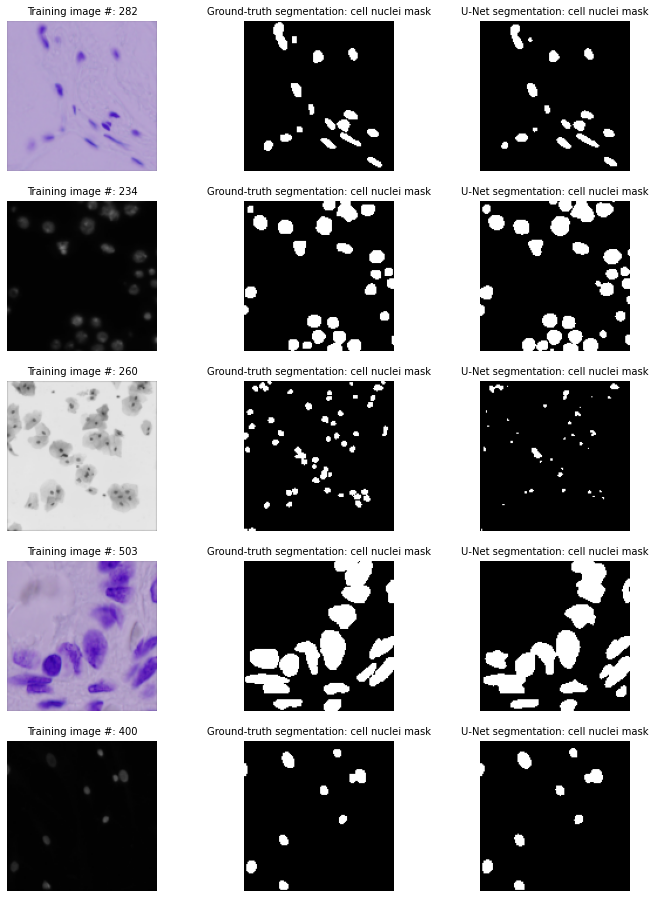

In [64]:
#-------------------------------------------------------------------------------
# Recall we used 10% of the training data for validation:
#-------------------------------------------------------------------------------
# - So 90% o fthe training data subset was used fro training the model
# - It is assumed to be the first 90% images of the training data subset are 
#   used for training the U-Net model.
#-------------------------------------------------------------------------------
# define the last training image index
last_train_image_index = int(X_train.shape[0]*0.9)
#-------------------------------------------------------------------------------
# Compute the model predictions for all images ued for training:
#-------------------------------------------------------------------------------
#  - with indices: 0 to last_train_image_index:
#-------------------------------------------------------------------------------
train_preds = model.predict(X_train[:last_train_image_index], verbose=2)
#-------------------------------------------------------------------------------
# Apply a threshold to convert the mask to binary:
#-------------------------------------------------------------------------------
# - values > 0.5 are assumed to belong to the mask
#-------------------------------------------------------------------------------
train_preds = (train_preds > 0.5).astype(np.uint8)

#-------------------------------------------------------------------------------
# - Visualize 5 cell nuclei training images and their associated 
#   ground-truth cell nuclei masks as well as their predicted masks:
#-------------------------------------------------------------------------------
# specify the overall grid size
plt.figure(figsize=(12,16)) 
# the plot title
plt.title("U-Net segmentation of sample training images", fontsize=12)
# iterate over the 15 images
for i in range(0, 15, 3): 
    #---------------------------------------------------------------------------
    # Training image counter:
    #---------------------------------------------------------------------------
    # - generate a random index between 0 and last_train_image_index
    image_counter = random.randint(0, last_train_image_index)
    #---------------------------------------------------------------------------
    # step 1: create the subplot for the next image
    #---------------------------------------------------------------------------
    plt.subplot(5,3,i+1)  
    # display the image
    plt.imshow(X_train[image_counter])
    # figure title
    plt.title("Training image #: " + str(image_counter), fontsize=10)
    # turn-off axes
    plt.axis('off')
    #---------------------------------------------------------------------------
    # step 2: create the subplot for the image ground-truth nuclei mask
    #---------------------------------------------------------------------------
    plt.subplot(5,3,i+2)  
    # display the image
    plt.imshow(np.squeeze(Y_train[image_counter]), cmap='gray')
    # figure title
    plt.title("Ground-truth segmentation: cell nuclei mask", fontsize=10)
    # turn-off axes
    plt.axis('off')
    #---------------------------------------------------------------------------
    # step 3: create the subplot for the image predicted nuclei mask
    #---------------------------------------------------------------------------
    plt.subplot(5,3,i+3)  
    # display the image
    plt.imshow(np.squeeze(train_preds[image_counter]), cmap='gray')
    # figure title
    plt.title("U-Net segmentation: cell nuclei mask", fontsize=10)
    # turn-off axes
    plt.axis('off')

#### 5.2) Visualize some of the predictions of the trained U-Net model on the validation data subset:

3/3 - 2s


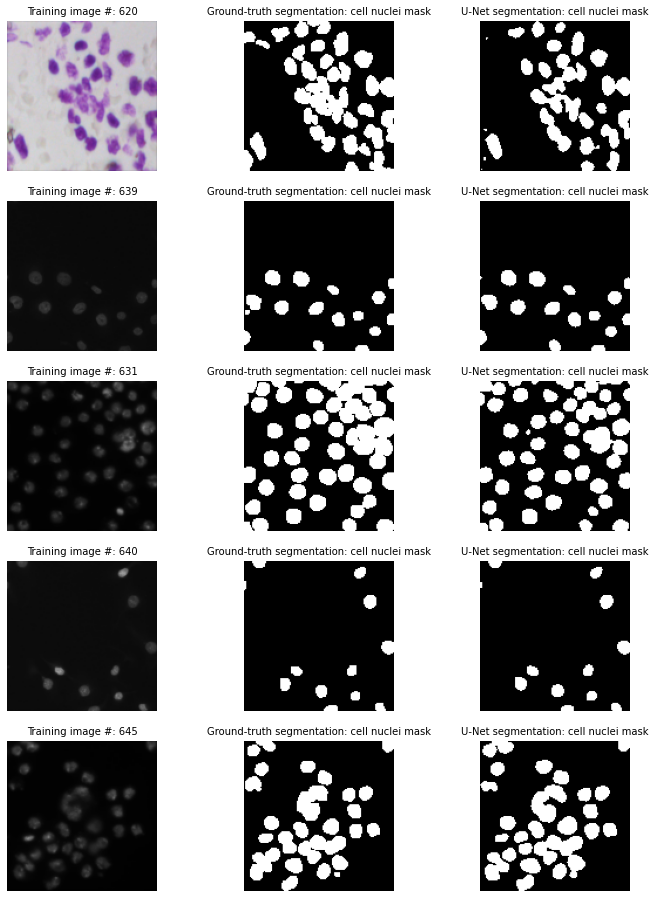

In [63]:
#-------------------------------------------------------------------------------
# Recall we used 10% of the training data for validation:
#-------------------------------------------------------------------------------
# - It is assumed that the last 10% images of the training data subset are 
#   used for validation.
#-------------------------------------------------------------------------------
# define the index of the first validation image
first_valid_image_index = int(X_train.shape[0]*0.9)
#-------------------------------------------------------------------------------
# Compute the model predictions for all images used for validation:
#-------------------------------------------------------------------------------
# with indices: first_valid_image_index to end
#-------------------------------------------------------------------------------
valid_preds = model.predict(X_train[first_valid_image_index:], verbose=2)
#-------------------------------------------------------------------------------
# Apply a threshold to convert the mask to binary:
#-------------------------------------------------------------------------------
# - values > 0.5 are assumed to belong to the mask
#-------------------------------------------------------------------------------
valid_preds = (valid_preds > 0.5).astype(np.uint8)

#-------------------------------------------------------------------------------
# - Visualize 5 cell nuclei validation images and their associated 
#   ground-truth cell nuclei masks as well as their predicted masks:
#-------------------------------------------------------------------------------
# specify the overall grid size
plt.figure(figsize=(12,16)) 
# create the figure title
plt.title("U-Net segmentation of sample validation images", fontsize=12)
# iterate over the 15 images
for i in range(0, 15, 3): 
    #---------------------------------------------------------------------------
    # Validation image counter:
    #---------------------------------------------------------------------------
    # - generate a random index between first_valid_image_index and num_train_images
    image_counter = random.randint(first_valid_image_index, num_train_images)
    #---------------------------------------------------------------------------
    # step 1: create the subplot for the next image
    #---------------------------------------------------------------------------
    plt.subplot(5,3,i+1)  
    # display the image
    plt.imshow(X_train[image_counter])
    # figure title
    plt.title("Training image #: " + str(image_counter), fontsize=10)
    # turn-off axes
    plt.axis('off')
    #---------------------------------------------------------------------------
    # step 2: create the subplot for the image ground-truth nuclei mask
    #---------------------------------------------------------------------------
    plt.subplot(5,3,i+2)  
    # display the image
    plt.imshow(np.squeeze(Y_train[image_counter]), cmap='gray')
    # figure title
    plt.title("Ground-truth segmentation: cell nuclei mask", fontsize=10)
    # turn-off axes
    plt.axis('off')
    #---------------------------------------------------------------------------
    # step 3: create the subplot for the image predicted nuclei mask
    #---------------------------------------------------------------------------
    plt.subplot(5,3,i+3)  
    # display the image
    plt.imshow(np.squeeze(valid_preds[image_counter % first_valid_image_index]), cmap='gray')
    # figure title
    plt.title("U-Net segmentation: cell nuclei mask", fontsize=10)
    # turn-off axes
    plt.axis('off')

#### 5.3) Visualize some of the predictions of the trained U-Net model on the test data subset:

3/3 - 2s


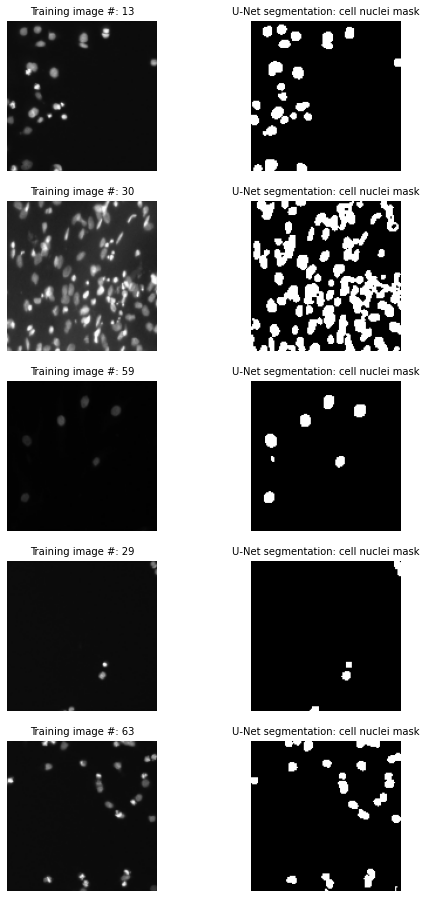

In [61]:
#-------------------------------------------------------------------------------
# Compute the model predictions for all test images:
#-------------------------------------------------------------------------------
test_preds = model.predict(X_test, verbose=2)
#-------------------------------------------------------------------------------
# Apply a threshold to convert the mask to binary:
#-------------------------------------------------------------------------------
# - values > 0.5 are assumed to belong to the mask
#-------------------------------------------------------------------------------
test_preds = (test_preds > 0.5).astype(np.uint8)

#-------------------------------------------------------------------------------
# - Visualize 5 cell nuclei test images and their predicted masks:
#-------------------------------------------------------------------------------
# test images do not have ground-truth cell nuclei masks
#-------------------------------------------------------------------------------
# specify the overall grid size
plt.figure(figsize=(8,16)) 
# create the figure title
plt.title("U-Net segmentation of sample validation images", fontsize=12)
# iterate over the 10 images
for i in range(0, 10, 2): 
    #---------------------------------------------------------------------------
    # Test image counter:
    #---------------------------------------------------------------------------
    # - generate a random index between 0 and num_test_images
    image_counter = random.randint(0, num_test_images - 1)
    #---------------------------------------------------------------------------
    # step 1: create the subplot for the next image
    #---------------------------------------------------------------------------
    plt.subplot(5,2,i+1)  
    # display the image
    plt.imshow(X_test[image_counter])
    # figure title
    plt.title("Training image #: " + str(image_counter), fontsize=10)
    # turn-off axes
    plt.axis('off')
    #---------------------------------------------------------------------------
    # step 2: create the subplot for the image predicted nuclei mask
    #---------------------------------------------------------------------------
    plt.subplot(5,2,i+2)  
    # display the image
    plt.imshow(np.squeeze(test_preds[image_counter]), cmap='gray')
    # figure title
    plt.title("U-Net segmentation: cell nuclei mask", fontsize=10)
    # turn-off axes
    plt.axis('off')

##**Step 7: Save the trained CNN model**
* Save the trained model fro future re-use.

In [65]:
# Save the trained model
model.save('cell_nuclei_seg_u-net_model_final_num_epochs_' + str(num_training_epochs) + '.h5')

##**Step 8: End of Execution**
* Display a successful end of execution message


In [66]:
# display a final message
# current time
now = datetime.datetime.now()
# display a message
print('Program executed successfully on: '+ str(now.strftime("%Y-%m-%d %H:%M:%S") + "...Goodbye!\n"))

Program executed successfully on: 2021-04-03 22:03:44...Goodbye!

